## Target(sii) Imputation 

Trondata cho trước,y, giá trị của su) không được biết cho 1224 hàng của tệp train.csv.

Trong notebook ntính toán chỉ các giá trị thiếu của sii cho 1224 hoán với độ chính xác cao.

Đầu tiên, "Features Imputation" được thựm thời cho tệp train.csv, sau đó tệp train.csv được tách thành hai phần. Phần đầu tiên chứa 2736 hàng và giá trị của sii đượh toán. Phần thứ hai chứa 1224 hàng mà giá trị của sii không chắc chắn và là phần kiểm tra tính toán.

Trong bước tiếp theo, hồi quy được thực hiện bằng cách sử dụng LGBM và các giá trị sii được tính toán với độ chính xác cao.

Trong bước cuối cùng, chỉ cột sii của tệp train.csv được hoàn thành bằng cách sử dụng các giá trị đã tính toán, sau đó nó được gửi dưới dạng đầu ra với tên train_sii.csv.


In [1]:
import numpy as np
import pandas as pd
import polars as pl
import os, time, copy 
import gc, json, random
from pathlib import Path

import itertools
from scipy import stats
from scipy.optimize import minimize
from scipy.spatial.distance import cdist


import lightgbm as lgb
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from colorama import Style, Fore
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from bayes_opt import BayesianOptimization
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import log_loss
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import ConfusionMatrixDisplay
%matplotlib inline

# ............................................
import warnings
warnings.filterwarnings('ignore')
!ls ../input/*

data_dictionary.csv    series_test.parquet   test.csv
sample_submission.csv  series_train.parquet  train.csv


In [2]:
dtrain = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv', index_col='id')
dtest = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv', index_col='id')
sub_sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

dtrain_col = dtrain.columns.tolist()
dtest_col = dtest.columns.tolist()

dtrain.shape, dtest.shape, sub_sample.shape

((3960, 81), (20, 58), (20, 2))

# Missing Values

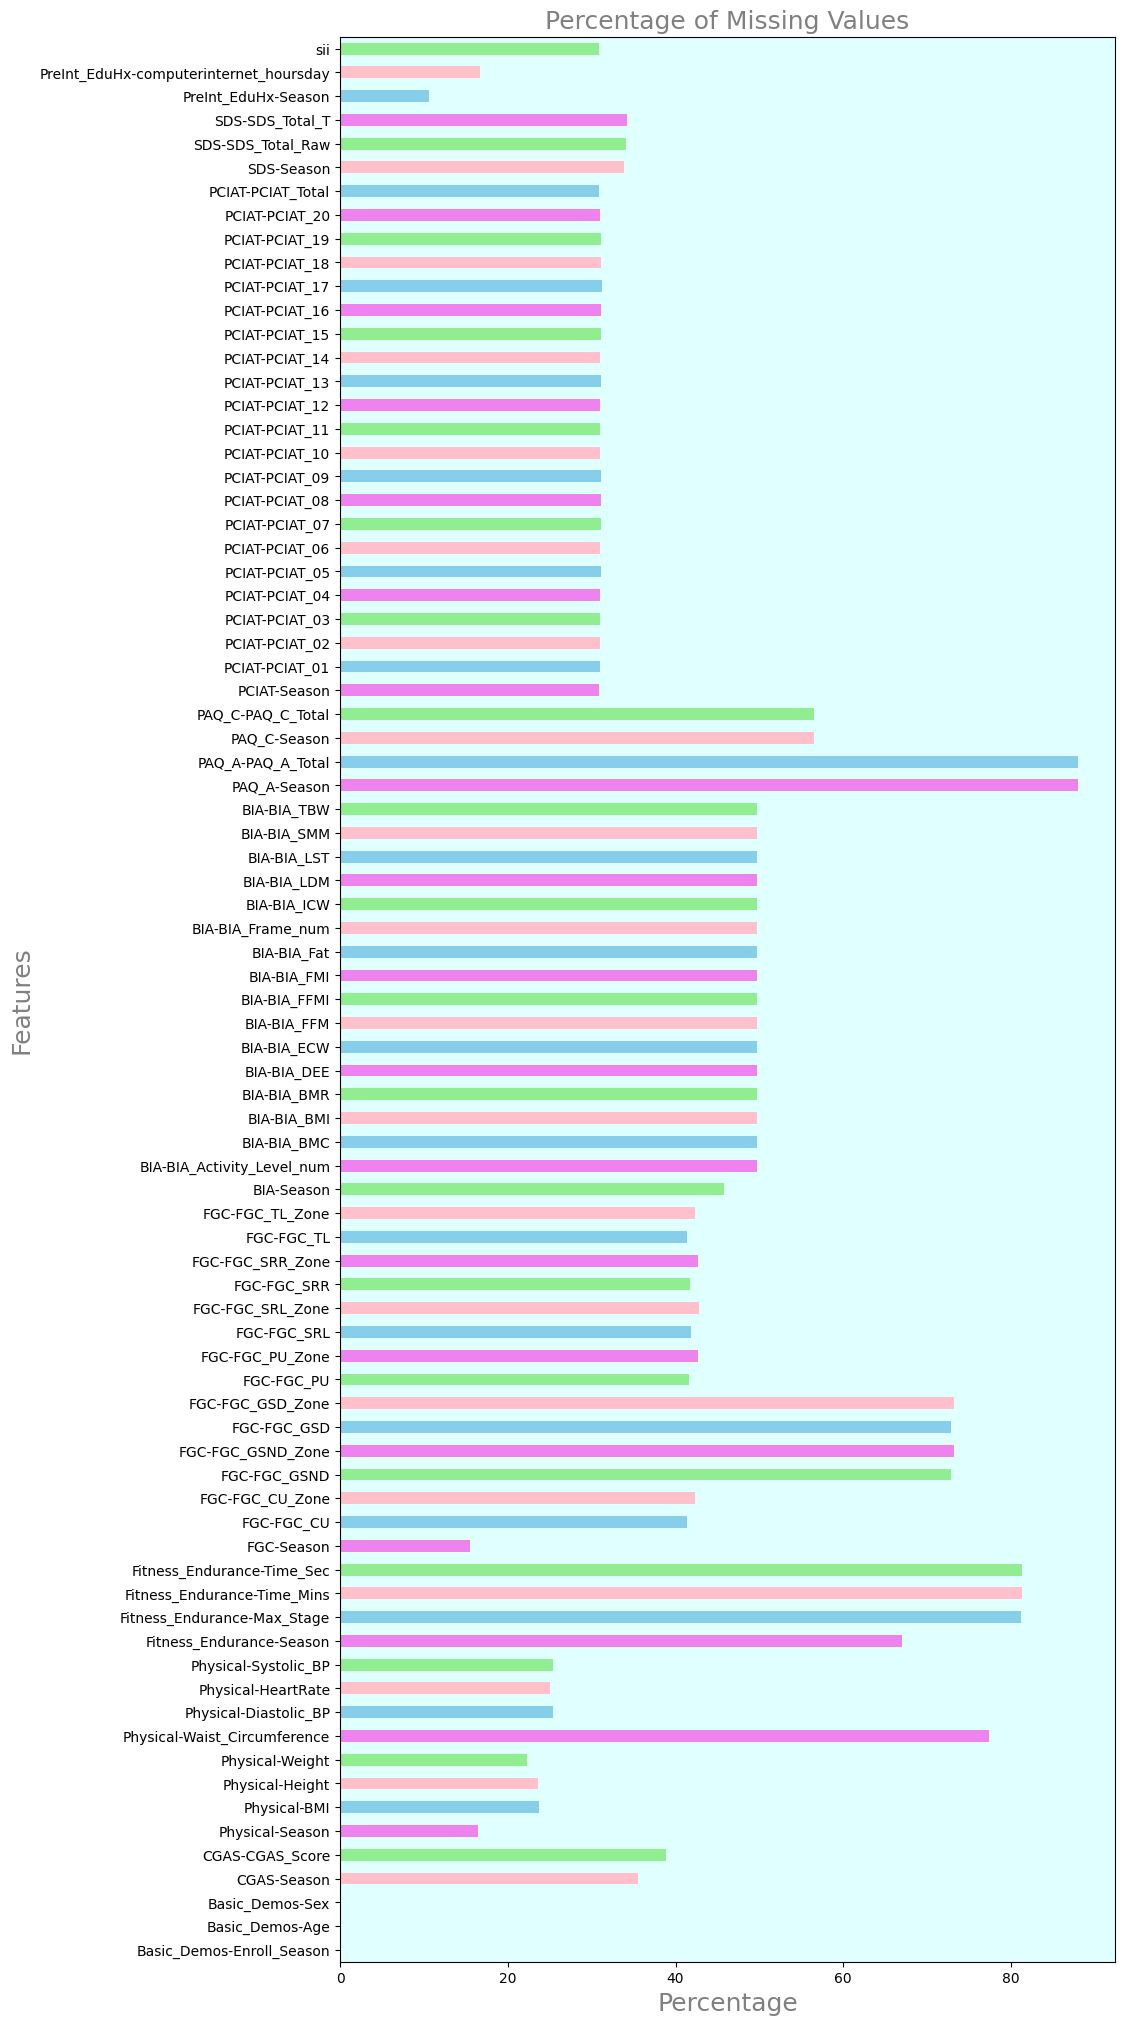

In [3]:
train = dtrain.copy()
test = dtest.copy()

train_col = train.columns.tolist()
test_col = test.columns.tolist()

missing_values = train.isnull().mean() * 100
missing_values.plot(kind='barh', figsize=(10, 25), color=['lightgreen','violet','skyblue','pink'])

plt.title('Percentage of Missing Values', fontsize=18, color='gray')
plt.xlabel('Percentage', fontsize=18, color='gray')
plt.ylabel('Features', fontsize=18, color='gray')
plt.gca().set_facecolor('lightcyan')
plt.xticks(rotation=0)
plt.show();

# Features

In [4]:
features = test_col.copy()
print('Number of Features :', len(features))

# Numerical Features
num_features = [f for f in features if train[f].dtype==float or f=='Basic_Demos-Age']
print('The number of numerical features :', len(num_features))

# Categorical Features
cat_features = [f for f in features if f not in num_features]
print('The number of categorical features :', len(cat_features))

# Target Features
target_col = [f for f in train_col if f not in test_col]
print('The number of target features :', len(target_col), '\n')

# Unique Number
# pd.set_option('display.max_rows', 500)
pd.DataFrame(data= {'Unique number in train': train[features].nunique(), 
                    'Unique number in test': test[features].nunique()}).sort_values(by=['Unique number in train']) 

Number of Features : 58
The number of numerical features : 47
The number of categorical features : 11
The number of target features : 23 



,Unique number in train,Unique number in test
Basic_Demos-Sex,2,2
FGC-FGC_TL_Zone,2,2
FGC-FGC_SRR_Zone,2,2
FGC-FGC_SRL_Zone,2,2
FGC-FGC_PU_Zone,2,2
FGC-FGC_CU_Zone,2,2
BIA-BIA_Frame_num,3,2
FGC-FGC_GSD_Zone,3,2
FGC-FGC_GSND_Zone,3,2
Basic_Demos-Enroll_Season,4,4


# Features Imputation

In [5]:
from sklearn.impute import KNNImputer
imputer_num = KNNImputer(n_neighbors=2, weights="uniform")

# ....................................................................................
num_train = [f for f in train_col if train[f].dtype==float or f=='Basic_Demos-Age']
fit_train = [f for f in num_train if f!='sii']

imputer_num.fit(train[fit_train])
train[fit_train] = imputer_num.transform(train[fit_train])

cat_train = [f for f in train_col if f not in fit_train and f!='sii']

for col in cat_train:
    train[col] = train[col].fillna('unknown')
    train[col] = train[col].astype('category')
    
# ....................................................................................
train.isnull().mean() * 100

Basic_Demos-Enroll_Season                  0.000000
Basic_Demos-Age                            0.000000
Basic_Demos-Sex                            0.000000
CGAS-Season                                0.000000
CGAS-CGAS_Score                            0.000000
                                            ...    
SDS-SDS_Total_Raw                          0.000000
SDS-SDS_Total_T                            0.000000
PreInt_EduHx-Season                        0.000000
PreInt_EduHx-computerinternet_hoursday     0.000000
sii                                       30.909091
Length: 81, dtype: float64

In [6]:
train_code = pd.get_dummies(train, columns=cat_train)

# ......................................................................
# StandardScaler
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# train_code[fit_train] = scaler.fit_transform(train_code[fit_train])

# ......................................................................
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# train_code[fit_train] = scaler.fit_transform(train_code[fit_train])

# ......................................................................
train_code.shape

(3960, 125)

In [7]:
train_sii = train_code[train_code['sii'].notna()].copy()
test_sii = train_code[train_code['sii'].isna()].copy()

y_sii  = train_sii['sii'].copy()
X_sii  = train_sii.drop(columns=['sii']).copy()
XX_sii = test_sii.drop(columns=['sii']).copy()

y_sii.shape, X_sii.shape, XX_sii.shape

((2736,), (2736, 124), (1224, 124))

In [8]:
def round_t(pred_raw, t):
    pred = np.where(pred_raw < t[0], 0, np.where(pred_raw < t[1], 1, np.where(pred_raw < t[2], 2, 3)))
    return pred

def qw_kappa(y_true, pred):
    return -cohen_kappa_score(y_true, pred, weights='quadratic')

# Thanks to: @ambrosm
def fun(t, y_true, pred_raw):
    pred = round_t(pred_raw, t)
    return -cohen_kappa_score(y_true, pred, weights='quadratic')

def optimized_thresholds(fun, y_true, pred_raw):
    res = minimize(fun, x0=[0.5, 1.5, 2.5], args=(y_true, pred_raw), method='Nelder-Mead')
    assert res.success
    return res.x.round(2) # optimized_thresholds

t = [0.60, 1.07, 2.52] # Optimized Thresholds (initial)

In [9]:
lgbm_params1 = {  
    
    'metric'              :'rmse',
    'objective'           :'regression',
    'learning_rate'       : 0.04,
    'max_depth'           : 12,
    'num_leaves'          : 59,
    'subsample'           : 0.70,
    'colsample_bytree'    : 0.50,
    'min_child_weight'    : 12, 
    'min_child_samples'   : 14,    
    'reg_alpha'           : 0.23,
    'reg_lambda'          : 0.36,
}

# ::::::::::::::::::::::::::::::::::::::::::::::::
lgbm_params2 = {  
    
    'metric'              :'rmse',
    'objective'           :'regression',
    'learning_rate'       : 0.05,
    'max_depth'           : 9,
    'num_leaves'          : 59,
    'subsample'           : 0.80,
    'colsample_bytree'    : 0.50,
    'min_child_weight'    : 12, 
    'min_child_samples'   : 14,  
    'reg_alpha'           : 0.23,
    'reg_lambda'          : 0.36,
}

# ::::::::::::::::::::::::::::::::::::::::::::::::
lgbm_params3 = {  
    
    'metric'              :'rmse',
    'objective'           :'regression',
    'learning_rate'       : 0.046,
    'max_depth'           : 12,
    'num_leaves'          : 478,
    'min_data_in_leaf'    : 13,
    'feature_fraction'    : 0.893,
    'bagging_fraction'    : 0.784,
    'bagging_freq'        : 4,
    'lambda_l1'           : 10, 
    'lambda_l2'           : 0.01, 
}
                                                       
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

model1 = lgb.LGBMRegressor(**lgbm_params1, n_estimators=10000, random_state=421, early_stopping_rounds=350, verbose=-1)

model2 = lgb.LGBMRegressor(**lgbm_params2, n_estimators=10000, random_state=422, early_stopping_rounds=350, verbose=-1)

model3 = lgb.LGBMRegressor(**lgbm_params3, n_estimators=10000, random_state=423, early_stopping_rounds=350, verbose=-1)

# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

model_list = [model1, model2, model3]

In [10]:
score_mean = 0
pred = np.zeros(len(XX_sii))
rkf = RepeatedKFold(n_splits=3, n_repeats=6, random_state=424)

for fold, (train_idx, valid_idx) in enumerate(rkf.split(X_sii)):  
    X_train, y_train = X_sii.iloc[train_idx], y_sii.iloc[train_idx]
    X_valid, y_valid = X_sii.iloc[valid_idx], y_sii.iloc[valid_idx]  

    print(f'\n:::::::::::::::::: Fold ~ {fold+1} :::::::::::::::::::')
    N = random.randrange(4) 
         
    if (N==0):
        print('LGBMRegressor - 1')
        model1.fit(X_train, y_train,             
                  eval_set=[(X_valid, y_valid)])        
        oof = model1.predict(X_valid)
        prd = model1.predict(XX_sii)
 
    if (N==1):
        print('LGBMRegressor - 2')
        model2.fit(X_train, y_train,             
                  eval_set=[(X_valid, y_valid)])      
        oof = model2.predict(X_valid)
        prd = model2.predict(XX_sii)
 
    if (N==2 or N==3):
        print('LGBMRegressor - 3')
        model3.fit(X_train, y_train,             
                  eval_set=[(X_valid, y_valid)])        
        oof = model3.predict(X_valid)
        prd = model3.predict(XX_sii) 
          
    score = cohen_kappa_score(y_valid, np.round(oof), weights='quadratic')
    print('SCORE:', round(score, 4))
                              
    score_mean += score 
    pred += prd
    
score_mean = score_mean / rkf.get_n_splits(X_sii, y_sii)    
preds_sii_raw = pred / rkf.get_n_splits(X_sii, y_sii)
preds_sii = np.round(preds_sii_raw)

print('\n', '='* 40)
print(' .'* 20)
print(' SCORE(mean):', score_mean)
print(' .'* 20)
print('='* 40, '\n')


:::::::::::::::::: Fold ~ 1 :::::::::::::::::::
LGBMRegressor - 3
SCORE: 1.0

:::::::::::::::::: Fold ~ 2 :::::::::::::::::::
LGBMRegressor - 1
SCORE: 1.0

:::::::::::::::::: Fold ~ 3 :::::::::::::::::::
LGBMRegressor - 3
SCORE: 1.0

:::::::::::::::::: Fold ~ 4 :::::::::::::::::::
LGBMRegressor - 3
SCORE: 1.0

:::::::::::::::::: Fold ~ 5 :::::::::::::::::::
LGBMRegressor - 1
SCORE: 0.9982

:::::::::::::::::: Fold ~ 6 :::::::::::::::::::
LGBMRegressor - 1
SCORE: 1.0

:::::::::::::::::: Fold ~ 7 :::::::::::::::::::
LGBMRegressor - 1
SCORE: 1.0

:::::::::::::::::: Fold ~ 8 :::::::::::::::::::
LGBMRegressor - 3
SCORE: 1.0

:::::::::::::::::: Fold ~ 9 :::::::::::::::::::
LGBMRegressor - 3
SCORE: 0.9864

:::::::::::::::::: Fold ~ 10 :::::::::::::::::::
LGBMRegressor - 2
SCORE: 0.999

:::::::::::::::::: Fold ~ 11 :::::::::::::::::::
LGBMRegressor - 3
SCORE: 1.0

:::::::::::::::::: Fold ~ 12 :::::::::::::::::::
LGBMRegressor - 3
SCORE: 0.9823

:::::::::::::::::: Fold ~ 13 :::::::::::::::::::


(-0.007, 2.596)

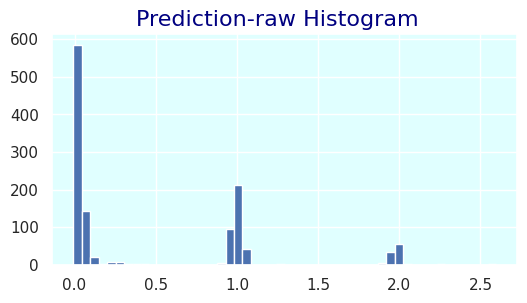

In [11]:
sns.set()
plt.figure(figsize=(6, 3))
plt.hist(preds_sii_raw, bins=50)

plt.gca().set_facecolor('lightcyan')
plt.suptitle('Prediction-raw Histogram', y=0.96, fontsize=16, c='navy')

round(min(preds_sii_raw), 3), round(max(preds_sii_raw), 3)

(0.0, 3.0)

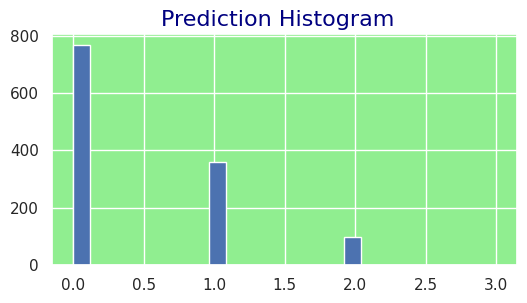

In [12]:
sns.set()
plt.figure(figsize=(6, 3))
plt.hist(preds_sii, bins=25)

plt.gca().set_facecolor('lightgreen')
plt.suptitle('Prediction Histogram', y=0.96, fontsize=16, c='navy')

min(preds_sii), max(preds_sii)

In [13]:
from lightgbm import plot_importance   

model0 = lgb.LGBMRegressor(**lgbm_params1, verbose=-1)
model0.fit(X_sii, y_sii)

LGBMRegressor(colsample_bytree=0.5, learning_rate=0.04, max_depth=12,
              metric='rmse', min_child_samples=14, min_child_weight=12,
              num_leaves=59, objective='regression', reg_alpha=0.23,
              reg_lambda=0.36, subsample=0.7, verbose=-1)

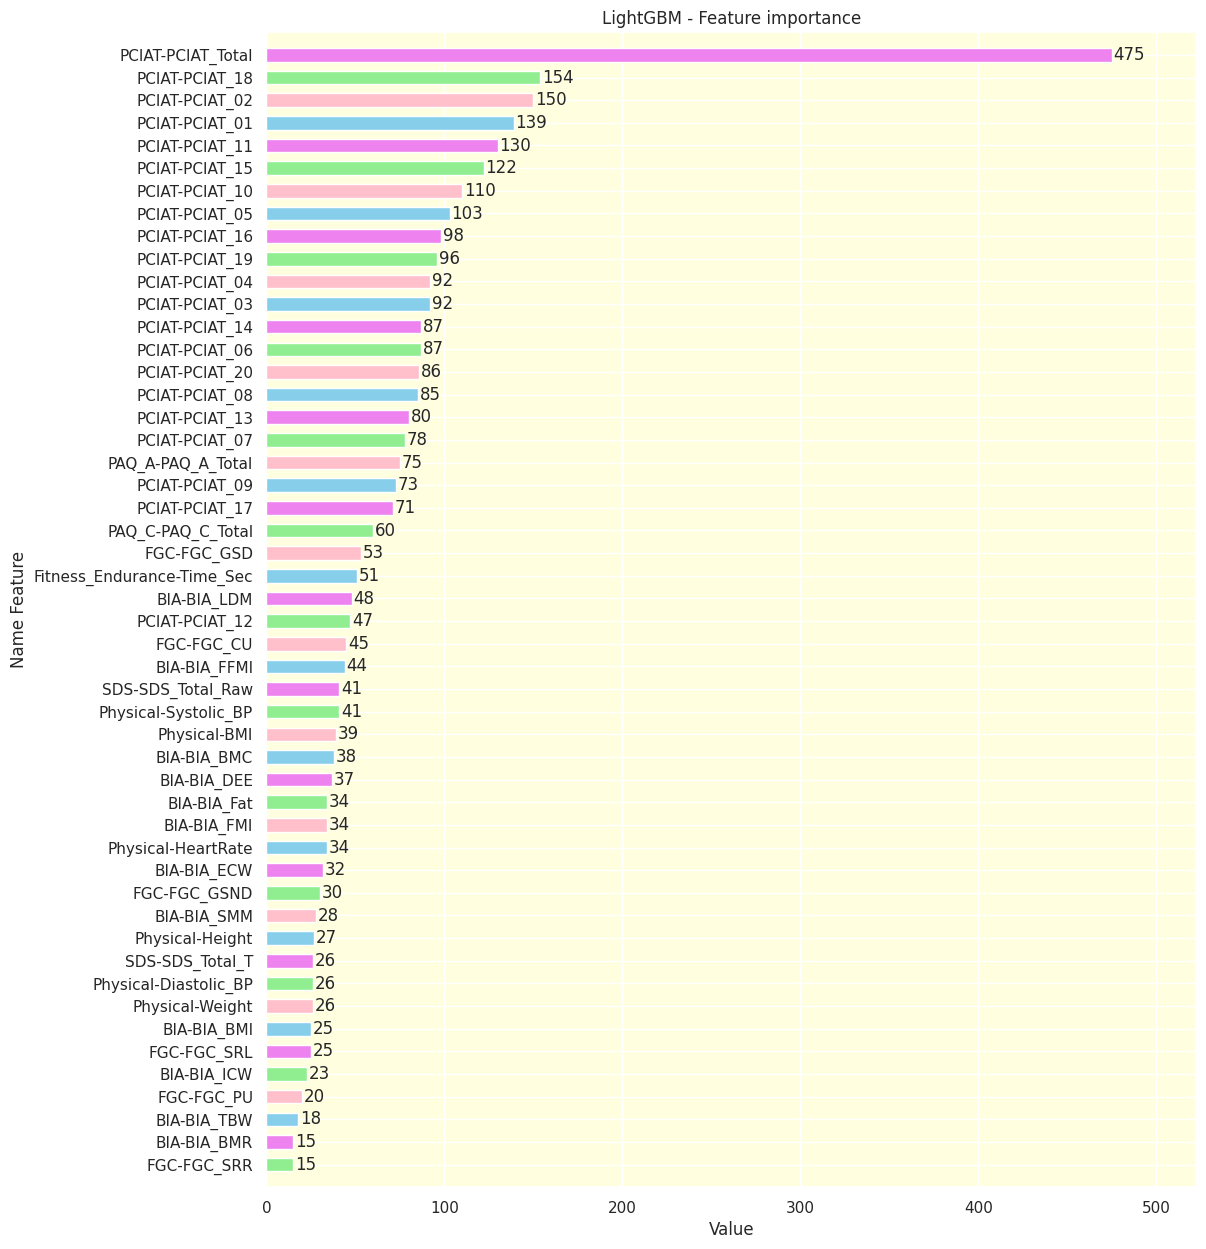

In [14]:
plot_importance(model0, figsize=(12, 15), color=['lightgreen','violet','skyblue','pink'], height=0.6, max_num_features=50,
                title='LightGBM - Feature importance', xlabel='Value', ylabel='Name Feature');

plt.gca().set_facecolor('lightyellow')

In [15]:
X_sii['sii'] = y_sii.copy()
XX_sii['sii'] = preds_sii.copy()

# .................................................
train_imput = pd.concat([X_sii, XX_sii], axis=0)
train_imput.sort_index(axis=0, inplace=True)

# .................................................
train_sii = dtrain.copy()
train_sii['sii'] = train_imput['sii']

train_imput.shape, train_sii.shape

((3960, 125), (3960, 81))

In [16]:
train_sii.to_csv('train_sii.csv', index=True)
!ls

__notebook__.ipynb  train_sii.csv


In [17]:
train_sii.isnull().mean() * 100

Basic_Demos-Enroll_Season                  0.000000
Basic_Demos-Age                            0.000000
Basic_Demos-Sex                            0.000000
CGAS-Season                               35.479798
CGAS-CGAS_Score                           38.863636
                                            ...    
SDS-SDS_Total_Raw                         34.116162
SDS-SDS_Total_T                           34.191919
PreInt_EduHx-Season                       10.606061
PreInt_EduHx-computerinternet_hoursday    16.641414
sii                                        0.000000
Length: 81, dtype: float64

In [18]:
pd.DataFrame(data= {'Before | Unique number in dtrain[sii] ': dtrain['sii'].value_counts(), 
                    'After | Unique number in train_sii[sii] ': train_sii['sii'].value_counts()})

,Before | Unique number in dtrain[sii],After | Unique number in train_sii[sii]
sii,,
0.0,1594,2362
1.0,730,1088
2.0,378,475
3.0,34,35


In [19]:
corr = train_imput.corr(numeric_only=True).round(2)
corr.style.background_gradient(cmap='Pastel2')